In [1]:
import json
import pandas as pd
import os
import re

# auto reload
%load_ext autoreload
%autoreload 2

In [2]:
from const import D_MODEL_PAIR

paper_figure_folder_path = r"output/paper_figures"

# MATH-500

In [3]:
output_dir = "output/reasoning_traces/MATH500"

d_res_mapping = {

    # non-greedy decoding results (temperature = 0.6): results from the first trial
    "temp_0p6_first_trial": {             
        'llama-8B-withoutR': 'MATH-500_DeepSeek-R1-Distill-Llama-8B_withoutR_finished.jsonl',
        'llama-8B-withR': 'MATH-500_DeepSeek-R1-Distill-Llama-8B_withR.jsonl',

        'qwen-7B-withoutR': 'MATH-500_DeepSeek-R1-Distill-Qwen-7B_withoutR_finished.jsonl',
        'qwen-7B-withR': 'MATH-500_DeepSeek-R1-Distill-Qwen-7B_withR.jsonl',
        
        'qwen-1p5B-withoutR': 'MATH-500_DeepSeek-R1-Distill-Qwen-1.5B_withoutR_finished.jsonl',
        'qwen-1p5B-withR': 'MATH-500_DeepSeek-R1-Distill-Qwen-1.5B_withR.jsonl',

        'r1-full-withoutR': 'MATH-500_DeepSeek-R1-full_withoutR_finished.jsonl',
        'r1-full-withR': 'MATH-500_DeepSeek-R1-full_withR.jsonl',
    },

    # non-greedy decoding results (temperature = 0.6): retried results for the failed cases from the first trial
    "temp_0p6_retry": {             
        'llama-8B-withoutR_retry': 'MATH-500_DeepSeek-R1-Distill-Llama-8B_withoutR_finished_retry.jsonl',
        'llama-8B-withR_retry': 'MATH-500_DeepSeek-R1-Distill-Llama-8B_withR_retry.jsonl',

        'qwen-7B-withoutR_retry': 'MATH-500_DeepSeek-R1-Distill-Qwen-7B_withoutR_finished_retry.jsonl',
        'qwen-7B-withR_retry': 'MATH-500_DeepSeek-R1-Distill-Qwen-7B_withR_retry.jsonl',

        'qwen-1p5B-withoutR_retry': 'MATH-500_DeepSeek-R1-Distill-Qwen-1.5B_withoutR_finished_retry.jsonl',
        'qwen-1p5B-withR_retry': 'MATH-500_DeepSeek-R1-Distill-Qwen-1.5B_withR_retry.jsonl',
    },

    # greedy decoding results: results from the first trial
    "greedy_first_trial": {
        'llama-8B-withoutR': 'MATH-500_DeepSeek-R1-Distill-Llama-8B_withoutR_finished_greedy.jsonl',
        'llama-8B-withR': 'MATH-500_DeepSeek-R1-Distill-Llama-8B_withR_greedy.jsonl',

        'qwen-7B-withoutR': 'MATH-500_DeepSeek-R1-Distill-Qwen-7B_withoutR_finished_greedy.jsonl',
        'qwen-7B-withR': 'MATH-500_DeepSeek-R1-Distill-Qwen-7B_withR_greedy.jsonl',
        
        'qwen-1p5B-withoutR': 'MATH-500_DeepSeek-R1-Distill-Qwen-1.5B_withoutR_finished_greedy.jsonl',
        'qwen-1p5B-withR': 'MATH-500_DeepSeek-R1-Distill-Qwen-1.5B_withR_greedy.jsonl',
    }

}

In [4]:
use_greedy_results = False
include_retry_results = False

In [5]:
# Load results based on the specified conditions

l_res_scenario = []
if use_greedy_results:
    l_res_scenario.append("greedy_first_trial")
else:
    l_res_scenario.append("temp_0p6_first_trial")
    if include_retry_results:
        l_res_scenario.append("temp_0p6_retry")

df = pd.DataFrame()
for scenario, d_mapping in d_res_mapping.items():
    if scenario not in l_res_scenario:
        continue
    for k, v in d_mapping.items():
        with open(os.path.join(output_dir, v), 'r') as f:
            data = [json.loads(line) for line in f.readlines()]
            df_tmp = pd.DataFrame(data)
            df_tmp['setting'] = k
            if 'r1' in k:
                df_tmp =  df_tmp.rename(columns={'id': 'unique_id', 'prompt': 'problem'})
                df_tmp['response'] = df_tmp['response'] + '<｜end▁of▁sentence｜>'
                if 'withoutR' in k:
                    df_tmp['response'] = '<think>\n\n</think>' + df_tmp['response'] 
        df = pd.concat([df, df_tmp], ignore_index=True)
df = df.drop(columns=['latency'], errors='ignore')

print(df.shape)
df.head(2)

(4000, 4)


,unique_id,problem,response,setting
0,test/precalculus/807.json,"Convert the point $(0,3)$ in rectangular coord...","<｜begin▁of▁sentence｜>Convert the point $(0,3)$...",llama-8B-withoutR
1,test/intermediate_algebra/1994.json,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,<｜begin▁of▁sentence｜>Define\n\[p = \sum_{k = 1...,llama-8B-withoutR


In [6]:
def _extract_boxed_answer(response):
    # Find all \boxed{...} matches
    # This pattern will match nested braces within \boxed{} properly
    matches = re.findall(r'\\boxed{([^{}]*(?:\{[^{}]*\}[^{}]*)*)}', response)
    # If matches found, return the last one, otherwise return None
    if matches:
        return matches[-1]
    return None

df['is_response_finished'] = df['response'].apply(lambda x: 1 if x.endswith('<｜end▁of▁sentence｜>') else 0)
df['answer_pred'] = df['response'].apply(lambda x: x.split('</think>')[-1] if '</think>' in x else "")
df['extracted_answer'] = df['answer_pred'].apply(_extract_boxed_answer)
df['is_answer_extracted'] = df['extracted_answer'].apply(lambda x: 1 if x else 0)
df['end_think_count'] = df['response'].apply(lambda x: len(x.split('</think>'))) # count the number of </think> tags

In [8]:
from datasets import load_dataset
from utils.MATH_500_eval.grader import grade_answer


dataset = load_dataset("HuggingFaceH4/MATH-500", split='test')
df_dataset = pd.DataFrame(dataset)
df_dataset_meta = df_dataset[['unique_id', 'answer', 'subject', 'level']]

df_merge = pd.merge(df, df_dataset_meta, how='left', left_on='unique_id', right_on='unique_id')
df_merge['is_answer_correct'] = df_merge.apply(
    lambda row: int(grade_answer(row['extracted_answer'], row['answer'])),
    axis=1
)
df_merge.head(2)

Generating test split: 100%|██████████| 500/500 [00:00<00:00, 6394.18 examples/s]


,unique_id,problem,response,setting,is_response_finished,answer_pred,extracted_answer,is_answer_extracted,end_think_count,answer,subject,level,is_answer_correct
0,test/precalculus/807.json,"Convert the point $(0,3)$ in rectangular coord...","<｜begin▁of▁sentence｜>Convert the point $(0,3)$...",llama-8B-withoutR,1,\n\nTo convert the rectangular coordinates \((...,"(3, \frac{\pi}{2})",1,2,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,1
1,test/intermediate_algebra/1994.json,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,<｜begin▁of▁sentence｜>Define\n\[p = \sum_{k = 1...,llama-8B-withoutR,1,\n\nTo express the double sum \(\sum_{j = 1}^\...,p - q,1,2,p - q,Intermediate Algebra,5,1


In [9]:
# if including retry results, select only one valid result for each unique_id

if include_retry_results:
    df_merge['setting_aligned'] = df_merge['setting'].apply(lambda x: x.split('_')[0])

    def _select_valid_case(df_g):
        # Select the first valid case for each unique_id
        df_g = df_g.sort_values(by='setting')
        df_g_sel = df_g[(df_g['is_response_finished'] == 1)&(df_g['end_think_count'] == 2)&(df_g['is_answer_extracted'] == 1)]
        if df_g_sel.empty:
            return df_g.iloc[0]
        else:
            l_unique_answer = df_g_sel['is_answer_correct'].unique()
            assert len(l_unique_answer) == 1, f"Multiple unique answers found: {l_unique_answer}, model: {df_g['model'].iloc[0]}, unique_id: {df_g['unique_id'].iloc[0]}"
            return df_g_sel.iloc[0]

    df_merge = df_merge.groupby(['setting_aligned', 'unique_id']).apply(_select_valid_case).reset_index(drop=True)
    df_merge['setting'] = df_merge['setting_aligned']
    df_merge = df_merge.drop(columns=['setting_aligned'])

df_merge.head(2)

,unique_id,problem,response,setting,is_response_finished,answer_pred,extracted_answer,is_answer_extracted,end_think_count,answer,subject,level,is_answer_correct
0,test/precalculus/807.json,"Convert the point $(0,3)$ in rectangular coord...","<｜begin▁of▁sentence｜>Convert the point $(0,3)$...",llama-8B-withoutR,1,\n\nTo convert the rectangular coordinates \((...,"(3, \frac{\pi}{2})",1,2,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,1
1,test/intermediate_algebra/1994.json,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,<｜begin▁of▁sentence｜>Define\n\[p = \sum_{k = 1...,llama-8B-withoutR,1,\n\nTo express the double sum \(\sum_{j = 1}^\...,p - q,1,2,p - q,Intermediate Algebra,5,1


In [10]:
# find out data preprocessing details

def _filtering_funnel(df_g):
    return pd.Series({
        'num': len(df_g),
        'num_finished': len(df_g[df_g['is_response_finished'] == 1]),
        'num_finished_format': len(df_g[(df_g['is_response_finished'] == 1)&(df_g['end_think_count'] == 2)]),
        'num_finished_format_extracted': len(df_g[(df_g['is_response_finished'] == 1)&(df_g['end_think_count'] == 2)&(df_g['is_answer_extracted'] == 1)]),
    })

df_funnel = df_merge.groupby('setting').apply(_filtering_funnel).reset_index()
df_funnel

/tmp/ipykernel_3072118/2298529981.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_funnel = df_merge.groupby('setting').apply(_filtering_funnel).reset_index()


,setting,num,num_finished,num_finished_format,num_finished_format_extracted
0,llama-8B-withR,500,412,379,373
1,llama-8B-withoutR,500,490,489,465
2,qwen-1p5B-withR,500,421,421,415
3,qwen-1p5B-withoutR,500,483,474,459
4,qwen-7B-withR,500,470,470,466
5,qwen-7B-withoutR,500,496,490,483
6,r1-full-withR,500,500,499,493
7,r1-full-withoutR,500,500,499,491


In [11]:
# Requiring common_ids per model

# For each model, find the IDs that meet our criteria
valid_ids_by_model = {}
models = df_merge['setting'].unique()

for model in models:
    # Find valid IDs for this model (responses that are finished, have correct format, and have extractable answers)
    valid_ids = df_merge[(df_merge['setting'] == model) & 
                         (df_merge['is_response_finished'] == 1) & 
                         (df_merge['end_think_count'] == 2) & 
                         (df_merge['is_answer_extracted'] == 1)]['unique_id'].values
    valid_ids_by_model[model] = set(valid_ids)

d_common_ids = {}
for model, (withR, withoutR) in D_MODEL_PAIR.items():
    # Find common IDs between the two models
    ids_withR = valid_ids_by_model[withR]
    ids_withoutR = valid_ids_by_model[withoutR]
    
    # Find common IDs
    common_ids = ids_withR.intersection(ids_withoutR)

    print(model, ", len common_ids:", len(common_ids))
    
    # Store the common IDs
    d_common_ids[model] = common_ids

df_filter = pd.DataFrame()
for model, (withR, withoutR) in D_MODEL_PAIR.items():
    # Filter the DataFrame for the common IDs
    common_ids = d_common_ids[model]
    df_model = df_merge[(df_merge['setting'] == withR) | (df_merge['setting'] == withoutR)]
    df_model = df_model[df_model['unique_id'].isin(common_ids)]
    
    # Add a column to indicate the model type
    df_model['model_type'] = model
    
    # Append to the final DataFrame
    df_filter = pd.concat([df_filter, df_model], ignore_index=True)

R1-Llama-8B , len common_ids: 355
R1-Qwen-7B , len common_ids: 457
R1-Qwen-1.5B , len common_ids: 400
R1-Full , len common_ids: 490


In [15]:
# Perform p-value analysis

df_p = df_filter[['unique_id', 'model_type', 'setting', 'is_answer_correct']]

def _p_value_analysis(df_g):
    from scipy.stats import ttest_rel, ttest_ind
    
    # Separate the two models
    withR_scores = df_g[df_g['setting'].str.contains('withR')].sort_values(by='unique_id')['is_answer_correct']
    withoutR_scores = df_g[df_g['setting'].str.contains('withoutR')].sort_values(by='unique_id')['is_answer_correct']
    assert len(withoutR_scores) == len(withR_scores), f"Length mismatch: {len(withoutR_scores)} vs {len(withR_scores)}"
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(withR_scores, withoutR_scores)
    
    return pd.Series({
        't_stat': t_stat,
        'p_value': p_value
    })

df_p_value = df_p.groupby('model_type').apply(_p_value_analysis).reset_index()
df_p_value

/tmp/ipykernel_3072118/3381236554.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_p_value = df_p.groupby('model_type').apply(_p_value_analysis).reset_index()


,model_type,t_stat,p_value
0,R1-Full,4.804857,2.063203e-06
1,R1-Llama-8B,6.304538,8.608185e-10
2,R1-Qwen-1.5B,4.493444,9.192901e-06
3,R1-Qwen-7B,6.628513,9.598074e-11


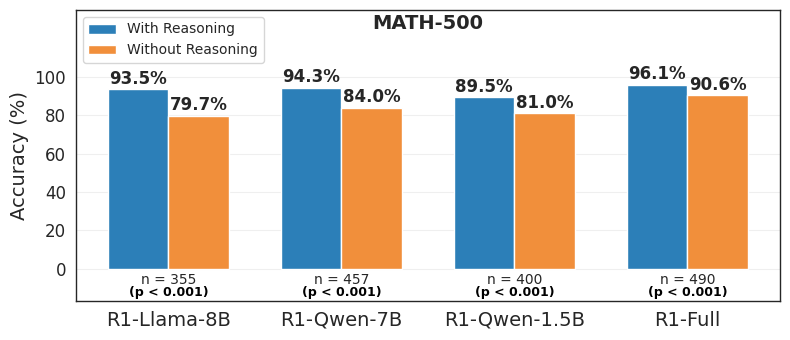

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Calculate accuracy for each model based on df_filter
model_accuracy = df_filter.groupby(['setting']).agg({
    'unique_id': 'count',
    'is_answer_correct': 'sum'
}).reset_index()

model_accuracy.rename(columns={'unique_id': 'problem_count'}, inplace=True)
model_accuracy['accuracy'] = model_accuracy['is_answer_correct'] / model_accuracy['problem_count']

# Extract base model name and reasoning type
model_accuracy['base_model'] = model_accuracy['setting'].apply(lambda x: '-'.join(x.split('-')[:-1]))
model_accuracy['reasoning_type'] = model_accuracy['setting'].apply(lambda x: 'With Reasoning' if 'withR' in x else 'Without Reasoning')

# Set up plot
plt.figure(figsize=(8, 3.5))
sns.set_style("white")

# Define colors and model pairs
colors = {'With Reasoning': '#2c7fb8', 'Without Reasoning': '#f18f3b'}
model_pairs = [
    ('llama-8B-withR', 'llama-8B-withoutR'),
    ('qwen-7B-withR', 'qwen-7B-withoutR'),
    ('qwen-1p5B-withR', 'qwen-1p5B-withoutR'),
    ('r1-full-withR', 'r1-full-withoutR')
]

# Set up bar positions
bar_width = 0.35
x = np.arange(len(model_pairs))

# Calculate sample sizes for each model pair
sample_sizes = []
for pair in model_pairs:
    withR, withoutR = pair
    # Get the sample size for this pair (they're the same for both models in a pair)
    sample_size = model_accuracy[model_accuracy['setting'] == withR]['problem_count'].values[0]
    sample_sizes.append(sample_size)

# Plot bars
for i, reasoning_type in enumerate(['With Reasoning', 'Without Reasoning']):
    data = model_accuracy[model_accuracy['reasoning_type'] == reasoning_type]
    # Ensure data is in the same order as model_pairs
    ordered_data = []
    for pair in model_pairs:
        model_name = pair[0] if reasoning_type == 'With Reasoning' else pair[1]
        model_data = data[data['setting'] == model_name]
        if not model_data.empty:
            ordered_data.append(model_data.iloc[0])
    
    if ordered_data:
        ordered_df = pd.DataFrame(ordered_data)
        bars = plt.bar(x + (i-0.5)*bar_width, ordered_df['accuracy'] * 100, 
                      width=bar_width, label=reasoning_type, color=colors[reasoning_type])
        
        # Add data labels (accuracy percentage)
        for j, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.8,
                    f'{height:.1f}%', 
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add sample size labels and p-values at the bottom of each bar pair
for i, size in enumerate(sample_sizes):
    # Get model type based on the index
    model_types = ['R1-Llama-8B', 'R1-Qwen-7B', 'R1-Qwen-1.5B', 'R1-Full']
    model_type = model_types[i]
    
    # Find p-value for this model
    p_val = df_p_value[df_p_value['model_type'] == model_type]['p_value'].values[0]
    p_val_formatted = f"(p = {p_val:.2e})" if p_val > 0.001 else f"(p < 0.001)"

    plt.text(i, -2.5, f"n = {size}", ha='center', va='top', fontsize=10)
    # Add p-value with bold font if significant (p < 0.05)
    plt.text(i, -9, p_val_formatted, ha='center', va='top', 
             fontsize=9, color='black', fontweight='bold' if p_val < 0.05 else 'normal')

# Customize plot
plt.ylabel('Accuracy (%)', fontsize=14)
# Set title below the top of the figure instead of above it
plt.text(x=1.5, y=125, s='MATH-500', 
         fontsize=14, fontweight='bold', ha='center')

# Set x-tick labels
x_labels = ['R1-Llama-8B', 'R1-Qwen-7B', 'R1-Qwen-1.5B', 'R1-Full']
plt.xticks(x, x_labels, fontsize=14)

plt.yticks(fontsize=12)
plt.ylim(-17, 135)  # Extend ylim to make room for sample size labels and p-values
plt.yticks(range(0, 101, 20))  # Only show ticks from 0 to 100 in steps of 20
plt.legend(loc=2, fontsize=10)

plt.tight_layout()

# Remove grid and add a border
plt.grid(axis='y', alpha=0.3)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.)

# # Save the figure
# save_fg_path = os.path.join(paper_figure_folder_path, 'quality_impact_MATH500_with_p_value.png')
# save_pdf_path = os.path.join(paper_figure_folder_path, 'quality_impact_MATH500_with_p_value.pdf')
# if not os.path.exists(os.path.dirname(save_fg_path)):
#     os.makedirs(os.path.dirname(save_fg_path))
# plt.savefig(save_fg_path, dpi=300, bbox_inches='tight')
# plt.savefig(save_pdf_path, bbox_inches='tight')

plt.show()

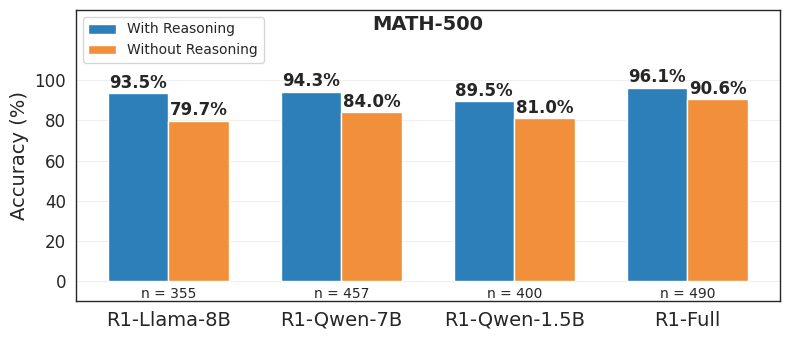

In [17]:
# Plotting without p-value info

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Calculate accuracy for each model based on df_filter
model_accuracy = df_filter.groupby(['setting']).agg({
    'unique_id': 'count',
    'is_answer_correct': 'sum'
}).reset_index()

model_accuracy.rename(columns={'unique_id': 'problem_count'}, inplace=True)
model_accuracy['accuracy'] = model_accuracy['is_answer_correct'] / model_accuracy['problem_count']

# Extract base model name and reasoning type
model_accuracy['base_model'] = model_accuracy['setting'].apply(lambda x: '-'.join(x.split('-')[:-1]))
model_accuracy['reasoning_type'] = model_accuracy['setting'].apply(lambda x: 'With Reasoning' if 'withR' in x else 'Without Reasoning')

# Set up plot
plt.figure(figsize=(8, 3.5))
sns.set_style("white")

# Define colors and model pairs
colors = {'With Reasoning': '#2c7fb8', 'Without Reasoning': '#f18f3b'}
model_pairs = [
    ('llama-8B-withR', 'llama-8B-withoutR'),
    ('qwen-7B-withR', 'qwen-7B-withoutR'),
    ('qwen-1p5B-withR', 'qwen-1p5B-withoutR'),
    ('r1-full-withR', 'r1-full-withoutR')
]

# Set up bar positions
bar_width = 0.35
x = np.arange(len(model_pairs))

# Calculate sample sizes for each model pair
sample_sizes = []
for pair in model_pairs:
    withR, withoutR = pair
    # Get the sample size for this pair (they're the same for both models in a pair)
    sample_size = model_accuracy[model_accuracy['setting'] == withR]['problem_count'].values[0]
    sample_sizes.append(sample_size)

# Plot bars
for i, reasoning_type in enumerate(['With Reasoning', 'Without Reasoning']):
    data = model_accuracy[model_accuracy['reasoning_type'] == reasoning_type]
    # Ensure data is in the same order as model_pairs
    ordered_data = []
    for pair in model_pairs:
        model_name = pair[0] if reasoning_type == 'With Reasoning' else pair[1]
        model_data = data[data['setting'] == model_name]
        if not model_data.empty:
            ordered_data.append(model_data.iloc[0])
    
    if ordered_data:
        ordered_df = pd.DataFrame(ordered_data)
        bars = plt.bar(x + (i-0.5)*bar_width, ordered_df['accuracy'] * 100, 
                      width=bar_width, label=reasoning_type, color=colors[reasoning_type])
        
        # Add data labels (accuracy percentage)
        for j, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.8,
                    f'{height:.1f}%', 
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add sample size labels and p-values at the bottom of each bar pair
for i, size in enumerate(sample_sizes):
    # Get model type based on the index
    model_types = ['R1-Llama-8B', 'R1-Qwen-7B', 'R1-Qwen-1.5B', 'R1-Full']
    model_type = model_types[i]
    
    # Find p-value for this model
    p_val = df_p_value[df_p_value['model_type'] == model_type]['p_value'].values[0]
    p_val_formatted = f"{p_val:.2e}"
    
    plt.text(i, -3, f"n = {size}", ha='center', va='top', fontsize=10)
    # plt.text(i, -7, f"(p = {p_val_formatted})", ha='center', va='top', fontsize=9, color='#555555')

# Customize plot
plt.ylabel('Accuracy (%)', fontsize=14)
# Set title below the top of the figure instead of above it
plt.text(x=1.5, y=125, s='MATH-500', 
         fontsize=14, fontweight='bold', ha='center')

# Set x-tick labels
x_labels = ['R1-Llama-8B', 'R1-Qwen-7B', 'R1-Qwen-1.5B', 'R1-Full']
plt.xticks(x, x_labels, fontsize=14)

plt.yticks(fontsize=12)
plt.ylim(-10, 135)  # Extend ylim to make room for sample size labels and p-values
plt.yticks(range(0, 101, 20))  # Only show ticks from 0 to 100 in steps of 20
plt.legend(loc=2, fontsize=10)

plt.tight_layout()

# Remove grid and add a border
plt.grid(axis='y', alpha=0.3)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.)

# # Save the figure
# save_fg_path = os.path.join(paper_figure_folder_path, 'quality_impact_MATH500.png')
# if not os.path.exists(os.path.dirname(save_fg_path)):
#     os.makedirs(os.path.dirname(save_fg_path))
# plt.savefig(save_fg_path, dpi=300, bbox_inches='tight')

plt.show()

# WildBench

In [4]:
output_dir = "output/reasoning_traces/WildBench"

# non-greedy decoding response file mapping (temperature = 0.6)
d_response_file_mapping = {
    'llama-8B-withoutR': 'WildBench_DeepSeek-R1-Distill-Llama-8B_withoutR_finished.jsonl',
    'llama-8B-withR': 'WildBench_DeepSeek-R1-Distill-Llama-8B_withR.jsonl',

    'qwen-7B-withoutR': 'WildBench_DeepSeek-R1-Distill-Qwen-7B_withoutR_finished.jsonl',
    'qwen-7B-withR': 'WildBench_DeepSeek-R1-Distill-Qwen-7B_withR.jsonl',

    'qwen-1p5B-withoutR': 'WildBench_DeepSeek-R1-Distill-Qwen-1.5B_withoutR_finished.jsonl',
    'qwen-1p5B-withR': 'WildBench_DeepSeek-R1-Distill-Qwen-1.5B_withR.jsonl',

    'r1-full-withoutR': 'WildBench_DeepSeek-R1-full_withoutR_finished.jsonl',
    'r1-full-withR': 'WildBench_DeepSeek-R1-full_withR.jsonl',
}

# eval results for the above response files
d_eval_res_mapping = {
    'llama-8B-withoutR': 'WildBench_DeepSeek-R1-Distill-Llama-8B_withoutR_finished_eval.jsonl',
    'llama-8B-withR': 'WildBench_DeepSeek-R1-Distill-Llama-8B_withR_eval.jsonl',

    'qwen-7B-withoutR': 'WildBench_DeepSeek-R1-Distill-Qwen-7B_withoutR_finished_eval.jsonl',
    'qwen-7B-withR': 'WildBench_DeepSeek-R1-Distill-Qwen-7B_withR_eval.jsonl',

    'qwen-1p5B-withoutR': 'WildBench_DeepSeek-R1-Distill-Qwen-1.5B_withoutR_finished_eval.jsonl',
    'qwen-1p5B-withR': 'WildBench_DeepSeek-R1-Distill-Qwen-1.5B_withR_eval.jsonl',

    'r1-full-withoutR': 'WildBench_DeepSeek-R1-full_withoutR_finished_eval.jsonl',
    'r1-full-withR': 'WildBench_DeepSeek-R1-full_withR_eval.jsonl',
}

In [5]:
df_response = pd.DataFrame()
for k, v in d_response_file_mapping.items():
    with open(os.path.join(output_dir, v), 'r') as f:
        data = f.readlines()
        data = [json.loads(line) for line in data]
        df_tmp = pd.DataFrame(data)        
        if 'r1' in k:
            df_tmp =  df_tmp.rename(columns={'id': 'unique_id', 'prompt': 'problem'})
            df_tmp['response'] = df_tmp['response'] + '<｜end▁of▁sentence｜>'
            if 'withoutR' in k:
                df_tmp['response'] = '<think>\n\n</think>' + df_tmp['response'] 
        df_tmp['setting'] = k
        df_response = pd.concat([df_response, df_tmp], ignore_index=True)
df_response = df_response.drop(columns=['latency'])
print(df_response.shape)
df_response.head(2)

(6257, 4)


,unique_id,problem,response,setting
0,ae006110bb364606,add 10 more balanced governments[aoc2]\n{\n\tG...,<｜begin▁of▁sentence｜>add 10 more balanced gove...,llama-8B-withoutR
1,8e03e31d4ed3413b,"For the following report, generate all the det...","<｜begin▁of▁sentence｜>For the following report,...",llama-8B-withoutR


In [6]:
df_eval = pd.DataFrame()
for k, v in d_eval_res_mapping.items():
    with open(os.path.join(output_dir, v), 'r') as f:
        data = json.load(f)
        df_tmp = pd.DataFrame(data)
        df_tmp['setting'] = k
    df_eval = pd.concat([df_eval, df_tmp], ignore_index=True)
df_eval['score'] = df_eval['parsed_result'].apply(lambda x: x['score'] if 'score' in x else None)
df_eval['score'] = pd.to_numeric(df_eval['score'], errors='coerce')
df_eval = df_eval.dropna(subset=['score'])
df_eval['unique_id'] = df_eval['session_id']
print(df_eval.shape)
df_eval.head(2)

(5512, 15)


,session_id,result,parsed_result,parsed,error,setting,uid,history,last_query,model_output,generator,eval_config,prompt,score,unique_id
0,1fd5099157f44366,"{\n ""strengths"": ""The AI response provides ...",{'strengths': 'The AI response provides a list...,True,None,llama-8B-withoutR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1fd5099157f44366
1,00f46b5fca4c4801,"\n{\n ""strengths"": ""The AI response accurat...",{'strengths': 'The AI response accurately expl...,True,None,llama-8B-withoutR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,00f46b5fca4c4801


In [7]:
df_combine = pd.merge(df_response, df_eval[['unique_id', 'setting', 'score']], on=['unique_id', 'setting'], how='inner')
df_combine.head(2)

,unique_id,problem,response,setting,score
0,ae006110bb364606,add 10 more balanced governments[aoc2]\n{\n\tG...,<｜begin▁of▁sentence｜>add 10 more balanced gove...,llama-8B-withoutR,8.0
1,8e03e31d4ed3413b,"For the following report, generate all the det...","<｜begin▁of▁sentence｜>For the following report,...",llama-8B-withoutR,8.0


In [8]:
df_combine['is_response_finished'] = df_combine['response'].apply(lambda x: 1 if x.endswith('<｜end▁of▁sentence｜>') else 0)
df_combine['answer'] = df_combine['response'].apply(lambda x: x.split('</think>')[-1] if '</think>' in x else "")
df_combine['end_think_count'] = df_combine['response'].apply(lambda x: len(x.split('</think>')))
df_combine['reasoning'] = df_combine['response'].apply(lambda x: x.split('</think>')[0].split('<think>')[-1] if '</think>' in x else "")
df_combine['prompt'] = df_combine['response'].apply(lambda x: x.split('<think>')[0] if '<think>' in x else "")

In [9]:
from datasets import load_dataset

test_data = load_dataset("allenai/WildBench", "v2", split="test")

df_wb_test = pd.DataFrame(test_data)
df_wb_test.head(2)

/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,id,session_id,conversation_input,references,length,checklist,intent,primary_tag,secondary_tags
0,ae006110bb364606,ae006110bb364606,[{'content': 'add 10 more balanced governments...,{'gpt-4': 'It looks like you're trying to crea...,1,[Does the AI output include 10 new balanced go...,The user wants to add 10 more balanced governm...,Editing,[Coding & Debugging]
1,8e03e31d4ed3413b,8e03e31d4ed3413b,"[{'content': 'For the following report, genera...",{'gpt-4': 'Details for the Benefit Register: ...,1,[Does the AI output accurately identify and li...,The user wants to generate all the details nee...,Planning,"[Information seeking, Reasoning]"


In [24]:
# Map primary tags to areas in order to improve data statistics

d_tag_area_mapping = {
    'Advice seeking': "Information\nSeeking",
    "Brainstorming": "Creative\nTasks",
    'Coding & Debugging': "Coding &\nAnalysis",
    'Creative Writing': "Creative\nTasks",
    'Data Analysis': "Coding &\nAnalysis",
    'Editing': "Creative\nTasks",
    'Information seeking': "Information\nSeeking",
    'Math': "Coding &\nAnalysis",
    'Planning': "Reasoning\n& Planning",
    'Reasoning': "Reasoning\n& Planning",
    'Role playing': "Creative\nTasks",
}
df_wb_test['area'] = df_wb_test['primary_tag'].map(d_tag_area_mapping)

In [25]:
df_merge = pd.merge(df_combine, df_wb_test[['session_id', 'primary_tag', 'area']], left_on='unique_id', right_on='session_id', how='left')

# Filter out 'Math' primary tag, as math problems in WildBench are not evaluated with ground truth answers
df_merge = df_merge[df_merge['primary_tag'] != 'Math']
df_merge.head(2)

,unique_id,problem,response,setting,score,is_response_finished,answer,end_think_count,reasoning,prompt,session_id,primary_tag,area
0,ae006110bb364606,add 10 more balanced governments[aoc2]\n{\n\tG...,<｜begin▁of▁sentence｜>add 10 more balanced gove...,llama-8B-withoutR,8.0,1,"\n\nAlright, I've carefully analyzed the data ...",2,"\nOkay, I think I have finished thinking.\n",<｜begin▁of▁sentence｜>add 10 more balanced gove...,ae006110bb364606,Editing,Creative\nTasks
1,8e03e31d4ed3413b,"For the following report, generate all the det...","<｜begin▁of▁sentence｜>For the following report,...",llama-8B-withoutR,8.0,1,\n\n**Final Answer: Benefits Management Plan f...,2,"\nOkay, I think I have finished thinking.\n","<｜begin▁of▁sentence｜>For the following report,...",8e03e31d4ed3413b,Planning,Reasoning\n& Planning


In [26]:
# Require common IDs for each model pair

# For each model, find the IDs that meet our criteria
valid_ids_by_model = {}
models = df_merge['setting'].unique()

for model in models:
    valid_ids = df_merge[df_merge['setting']==model]['session_id'].values
    valid_ids_by_model[model] = set(valid_ids)

D_MODEL_PAIR = {
    'R1-Llama-8B': ('llama-8B-withR', 'llama-8B-withoutR'),
    'R1-Qwen-7B': ('qwen-7B-withR', 'qwen-7B-withoutR'),
    'R1-Qwen-1.5B': ('qwen-1p5B-withR', 'qwen-1p5B-withoutR'),
    'R1-Full': ('r1-full-withR', 'r1-full-withoutR')
}

d_common_ids = {}
for model, (withR, withoutR) in D_MODEL_PAIR.items():
    # Find common IDs between the two models
    ids_withR = valid_ids_by_model[withR]
    ids_withoutR = valid_ids_by_model[withoutR]
    
    # Find common IDs
    common_ids = ids_withR.intersection(ids_withoutR)

    print(model, ", len common_ids:", len(common_ids))
    
    # Store the common IDs
    d_common_ids[model] = common_ids

df_filter = pd.DataFrame()
for model, (withR, withoutR) in D_MODEL_PAIR.items():
    # Filter the DataFrame for the common IDs
    common_ids = d_common_ids[model]
    df_model = df_merge[(df_merge['setting'] == withR) | (df_merge['setting'] == withoutR)]
    df_model = df_model[df_model['session_id'].isin(common_ids)]
    
    # Add a column to indicate the model type
    df_model['model_type'] = model
    
    # Append to the final DataFrame
    df_filter = pd.concat([df_filter, df_model], ignore_index=True)

R1-Llama-8B , len common_ids: 633
R1-Qwen-7B , len common_ids: 613
R1-Qwen-1.5B , len common_ids: 486
R1-Full , len common_ids: 657


In [27]:
# p-value analysis

df_p = df_filter[['unique_id', 'model_type', 'setting', 'area', 'primary_tag', 'score']]
df_p.head(2)

def _p_value_analysis(df_g):
    from scipy.stats import ttest_rel, ttest_ind
    
    # Separate the two models
    withR_scores = df_g[df_g['setting'].str.contains('withR')].sort_values(by='unique_id')['score']
    withoutR_scores = df_g[df_g['setting'].str.contains('withoutR')].sort_values(by='unique_id')['score']
    assert len(withoutR_scores) == len(withR_scores), f"Length mismatch: {len(withoutR_scores)} vs {len(withR_scores)}"
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(withR_scores, withoutR_scores)
    
    return pd.Series({
        't_stat': t_stat,
        'p_value': p_value
    })

df_p_value_by_model_area = df_p.groupby(['model_type', 'area']).apply(_p_value_analysis).reset_index()
df_p_value_by_model = df_p.groupby(['model_type']).apply(_p_value_analysis).reset_index()

display(df_p_value_by_model_area)
display(df_p_value_by_model)

/tmp/ipykernel_28957/887854283.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_p_value_by_model_area = df_p.groupby(['model_type', 'area']).apply(_p_value_analysis).reset_index()
/tmp/ipykernel_28957/887854283.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_p_value_by_model = df_p.groupby(['model_type']).apply(_p_value_analysis).reset_index()


,model_type,area,t_stat,p_value
0,R1-Full,Coding &\nAnalysis,1.498106,1.360049e-01
1,R1-Full,Creative\nTasks,-0.869891,3.853438e-01
2,R1-Full,Information\nSeeking,-1.738233,8.510125e-02
3,R1-Full,Reasoning\n& Planning,1.495061,1.367524e-01
4,R1-Llama-8B,Coding &\nAnalysis,0.703477,4.828565e-01
5,R1-Llama-8B,Creative\nTasks,7.550572,1.270198e-12
6,R1-Llama-8B,Information\nSeeking,2.313894,2.262114e-02
7,R1-Llama-8B,Reasoning\n& Planning,2.980026,3.323614e-03
8,R1-Qwen-1.5B,Coding &\nAnalysis,-0.531477,5.961047e-01
9,R1-Qwen-1.5B,Creative\nTasks,5.062037,1.238980e-06


,model_type,t_stat,p_value
0,R1-Full,0.478632,6.323599e-01
1,R1-Llama-8B,7.482578,2.452354e-13
2,R1-Qwen-1.5B,5.362917,1.269769e-07
3,R1-Qwen-7B,5.086285,4.861953e-07


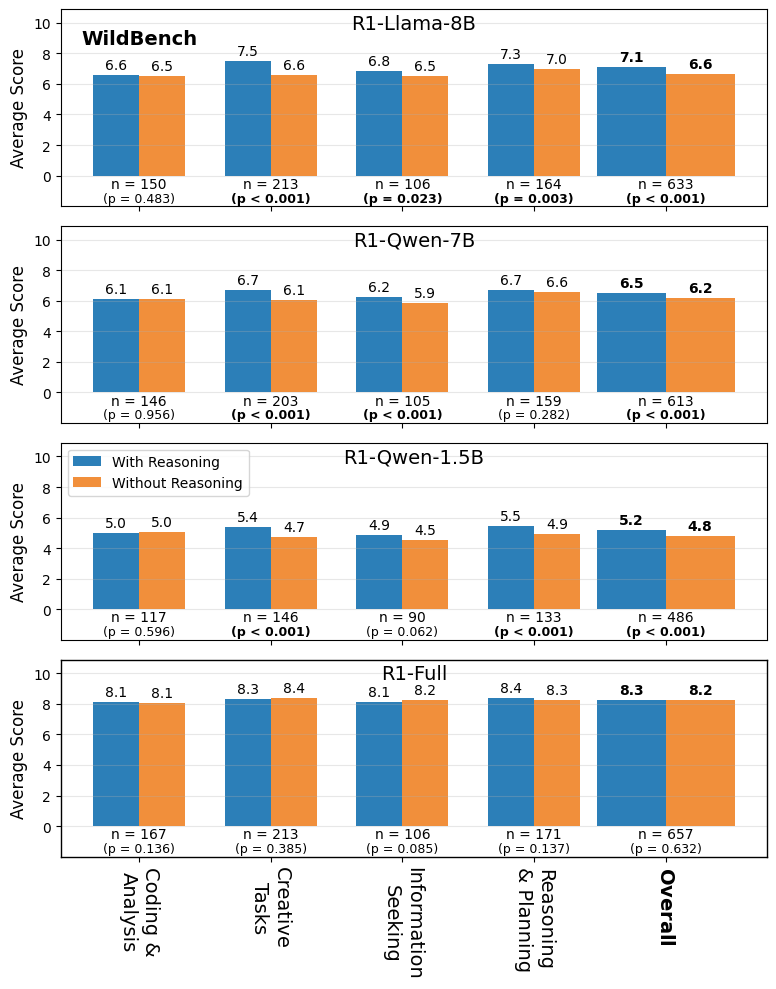

In [28]:
# plotting 

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_comparison_by_dimension(df_filter, D_MODEL_PAIR, dim='primary_tag', figsize=(8, 10), 
                                       df_p_value=None, df_p_value_overall=None):
    """
    Creates a comparison plot showing model performance across different categories.
    
    Parameters:
    -----------
    df_filter : DataFrame
        DataFrame containing the filtered data to plot
    D_MODEL_PAIR : dict
        Dictionary mapping model types to tuples of (withR, withoutR) model setting names
    dim : str, default='primary_tag'
        The dimension to group by (e.g., 'primary_tag', 'area')
    figsize : tuple, default=(8, 10)
        Size of the figure (width, height)
    df_p_value : DataFrame, optional
        DataFrame containing p-values with columns 'model_type', dimension name, and 'p_value'
    df_p_value_overall : DataFrame, optional
        DataFrame containing overall p-values with columns 'model_type' and 'p_value'
    """
    # Calculate accuracy for each model based on df_filter
    model_accuracy = df_filter.groupby(['setting']).agg({
        'session_id': 'count',
        'score': 'mean'
    }).reset_index()

    model_accuracy.rename(columns={'session_id': 'problem_count'}, inplace=True)

    # Extract base model name and reasoning type
    model_accuracy['base_model'] = model_accuracy['setting'].apply(lambda x: '-'.join(x.split('-')[:-1]))
    model_accuracy['reasoning_type'] = model_accuracy['setting'].apply(lambda x: 'With Reasoning' if 'withR' in x else 'Without Reasoning')

    # Filter the data to only include rows with the specified dimension
    df_with_dim = df_filter.dropna(subset=[dim])

    # Get unique model types and dimension values
    model_pairs = list(D_MODEL_PAIR.items())
    unique_values = sorted(df_with_dim[dim].unique())  # Sort values alphabetically

    # Create a figure with subplots - one for each model pair, stacked vertically
    fig, axes = plt.subplots(len(model_pairs), 1, figsize=figsize, sharex=True)

    # Colors for with and without reasoning
    colors = ['#2c7fb8', '#f18f3b']

    # Process each model pair
    for idx, (model_type, (withR, withoutR)) in enumerate(model_pairs):
        # Create a DataFrame to store average scores
        scores_by_value = []
        
        # Calculate average scores for each value for both versions
        for value in unique_values:
            # With reasoning
            withR_score = df_with_dim[(df_with_dim['setting'] == withR) & 
                                    (df_with_dim[dim] == value)]['score'].mean()
            
            # Without reasoning
            withoutR_score = df_with_dim[(df_with_dim['setting'] == withoutR) & 
                                       (df_with_dim[dim] == value)]['score'].mean()
            
            # Count of problems in this value
            count = df_with_dim[(df_with_dim['setting'].isin([withR, withoutR])) & 
                             (df_with_dim[dim] == value)]['unique_id'].nunique()
            
            # Get p-value from dimension-specific p-values if available
            p_value = None
            if df_p_value is not None:
                p_value_row = df_p_value[(df_p_value['model_type'] == model_type) & 
                                       (df_p_value[dim] == value)]
                if not p_value_row.empty:
                    p_value = p_value_row['p_value'].values[0]
            
            # Only include if we have data for both models
            if not (np.isnan(withR_score) or np.isnan(withoutR_score)):
                scores_by_value.append({
                    'value': value,
                    'withR': withR_score,
                    'withoutR': withoutR_score,
                    'diff': withR_score - withoutR_score,
                    'count': count,
                    'p_value': p_value
                })
        
        # Add the average scores from model_accuracy
        withR_avg = model_accuracy[model_accuracy['setting'] == withR]['score'].values[0]
        withoutR_avg = model_accuracy[model_accuracy['setting'] == withoutR]['score'].values[0]
        total_count = model_accuracy[model_accuracy['setting'] == withR]['problem_count'].values[0]
        
        # Get overall p-value from the overall p-values dataframe if available
        overall_p_value = None
        if df_p_value_overall is not None:
            overall_p_value_row = df_p_value_overall[df_p_value_overall['model_type'] == model_type]
            if not overall_p_value_row.empty:
                overall_p_value = overall_p_value_row['p_value'].values[0]
        
        scores_by_value.append({
            'value': 'Average',
            'withR': withR_avg,
            'withoutR': withoutR_avg,
            'diff': withR_avg - withoutR_avg,
            'count': total_count,
            'p_value': overall_p_value
        })
        
        # Convert to DataFrame and maintain the same order as unique_values + 'Average' at the end
        df_scores = pd.DataFrame(scores_by_value)
        if not df_scores.empty:
            # Make sure Average is at the end
            values_with_average = unique_values + ['Average']
            df_scores['value'] = pd.Categorical(df_scores['value'], categories=values_with_average, ordered=True)
            df_scores = df_scores.sort_values('value')
            
            # Get current axis
            ax = axes[idx]
            
            # Positions for bars
            x = np.arange(len(df_scores))
            width = 0.35
            avg_width = width * 1.5  # Make the average bar 50% wider
            
            # Plot bars - regular width for all values except Average
            for i, row in enumerate(df_scores.itertuples()):
                if row.value != 'Average':
                    # Regular values
                    ax.bar(x[i] - width/2, row.withR, width, color=colors[0])
                    ax.bar(x[i] + width/2, row.withoutR, width, color=colors[1])
                else:
                    # Average with wider bars
                    ax.bar(x[i] - avg_width/2, row.withR, avg_width, color=colors[0], label='With Reasoning')
                    ax.bar(x[i] + avg_width/2, row.withoutR, avg_width, color=colors[1], label='Without Reasoning')
            
            # Add sample size at the bottom of each bar pair and values on top
            for i, row in enumerate(df_scores.itertuples()):
                # Add sample size at bottom
                if row.value == 'Average':
                    # Add scores on top of bars for Average with bold font
                    ax.text(x[i] - avg_width/2, row.withR + 0.2, f"{row.withR:.1f}", 
                           ha='center', va='bottom', fontsize=10, fontweight='bold')
                    ax.text(x[i] + avg_width/2, row.withoutR + 0.2, f"{row.withoutR:.1f}", 
                           ha='center', va='bottom', fontsize=10, fontweight='bold')
                else:
                    ax.text(x[i] - avg_width/3, row.withR + 0.2, f"{row.withR:.1f}", 
                           ha='center', va='bottom', fontsize=10)
                    ax.text(x[i] + avg_width/3, row.withoutR + 0.2, f"{row.withoutR:.1f}", 
                           ha='center', va='bottom', fontsize=10)
                ax.text(x[i], -0.8, f"n = {row.count}", ha='center', fontsize=10)
                # Add p-value if available
                if hasattr(row, 'p_value') and row.p_value is not None:
                    p_val_text = f"(p = {row.p_value:.3f})" if row.p_value >= 0.001 else "(p < 0.001)"
                    ax.text(x[i], -1.7, p_val_text, ha='center', fontsize=9, fontweight='bold' if row.p_value < 0.05 else 'normal')
            
            # Add labels and title - positioned inside the plot area
            ax.set_ylabel('Average Score', fontsize=12)
            ax.tick_params(axis='y', labelsize=10)
            
            # Instead of setting title above plot, add text just below the top line
            ax.text(0.5, 0.9, f'{model_type}', fontsize=14, 
                    ha='center', transform=ax.transAxes)
                    
            # Add grid
            ax.grid(axis='y', alpha=0.3)
            
            ax.set_ylim(-1.99, 10.9)

    # Add legend to the middle subplot
    axes[len(axes)//2].legend(loc=2)

    # Set x-ticks and labels only for the bottom subplot
    axes[-1].set_xticks(x)
    # Create custom x-labels with Average in bold
    x_labels = []
    for value in df_scores['value']:
        if value == 'Average':
            x_labels.append(r'$\mathbf{Overall}$')
        else:
            x_labels.append(value)
    axes[-1].set_xticklabels(x_labels, rotation=-90, ha='center', fontsize=14)

    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.)

    axes[0].text(x=0., y=8.6, s='WildBench', 
             fontsize=14, fontweight='bold', ha='center')

    plt.tight_layout()
    
    return fig, axes

# Example usage:
# To use the original 'primary_tag' dimension with p-values
# fig, axes = plot_model_comparison_by_dimension(df_filter, D_MODEL_PAIR, dim='primary_tag', 
#                                               df_p_value=df_p_value_by_model_area, 
#                                               df_p_value_overall=df_p_value_by_model)
fig, axes = plot_model_comparison_by_dimension(df_filter, D_MODEL_PAIR, dim='area', 
                                              figsize=(8, 10), 
                                              df_p_value=df_p_value_by_model_area, 
                                              df_p_value_overall=df_p_value_by_model)

save_fg_path = os.path.join(paper_figure_folder_path, 'quality_impact_WildBench_with_p_value.png')
save_pdf_path = os.path.join(paper_figure_folder_path, 'quality_impact_WildBench_with_p_value.pdf')
if not os.path.exists(os.path.dirname(save_fg_path)):
    os.makedirs(os.path.dirname(save_fg_path))
plt.savefig(save_fg_path, dpi=300, bbox_inches='tight')
plt.savefig(save_pdf_path, bbox_inches='tight')


plt.show()


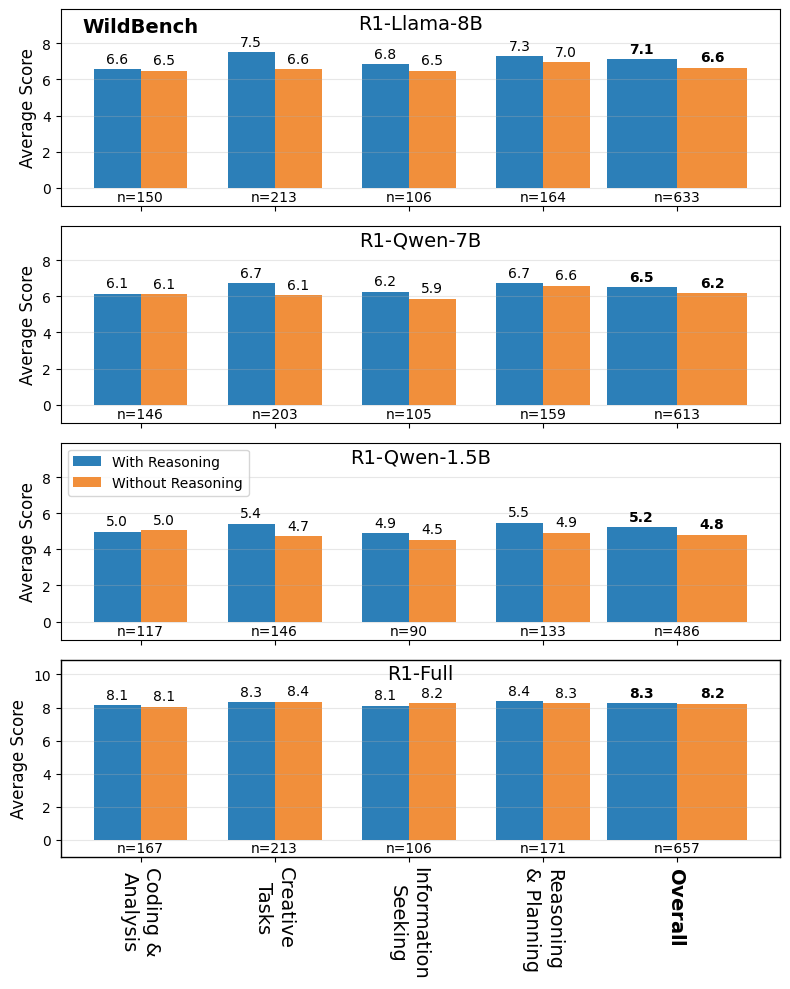

In [29]:
# plotting 

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_comparison_by_dimension(df_filter, D_MODEL_PAIR, dim='primary_tag', figsize=(8, 10)):
    """
    Creates a comparison plot showing model performance across different categories.
    
    Parameters:
    -----------
    df_filter : DataFrame
        DataFrame containing the filtered data to plot
    D_MODEL_PAIR : dict
        Dictionary mapping model types to tuples of (withR, withoutR) model setting names
    dim : str, default='primary_tag'
        The dimension to group by (e.g., 'primary_tag', 'area')
    figsize : tuple, default=(8, 10)
        Size of the figure (width, height)
    """
    # Calculate accuracy for each model based on df_filter
    model_accuracy = df_filter.groupby(['setting']).agg({
        'session_id': 'count',
        'score': 'mean'
    }).reset_index()

    model_accuracy.rename(columns={'session_id': 'problem_count'}, inplace=True)

    # Extract base model name and reasoning type
    model_accuracy['base_model'] = model_accuracy['setting'].apply(lambda x: '-'.join(x.split('-')[:-1]))
    model_accuracy['reasoning_type'] = model_accuracy['setting'].apply(lambda x: 'With Reasoning' if 'withR' in x else 'Without Reasoning')

    # Filter the data to only include rows with the specified dimension
    df_with_dim = df_filter.dropna(subset=[dim])

    # Get unique model types and dimension values
    model_pairs = list(D_MODEL_PAIR.items())
    unique_values = sorted(df_with_dim[dim].unique())  # Sort values alphabetically

    # Create a figure with subplots - one for each model pair, stacked vertically
    fig, axes = plt.subplots(len(model_pairs), 1, figsize=figsize, sharex=True)

    # Colors for with and without reasoning
    colors = ['#2c7fb8', '#f18f3b']

    # Process each model pair
    for idx, (model_type, (withR, withoutR)) in enumerate(model_pairs):
        # Create a DataFrame to store average scores
        scores_by_value = []
        
        # Calculate average scores for each value for both versions
        for value in unique_values:
            # With reasoning
            withR_score = df_with_dim[(df_with_dim['setting'] == withR) & 
                                    (df_with_dim[dim] == value)]['score'].mean()
            
            # Without reasoning
            withoutR_score = df_with_dim[(df_with_dim['setting'] == withoutR) & 
                                       (df_with_dim[dim] == value)]['score'].mean()
            
            # Count of problems in this value
            count = df_with_dim[(df_with_dim['setting'].isin([withR, withoutR])) & 
                             (df_with_dim[dim] == value)]['unique_id'].nunique()
            
            # Only include if we have data for both models
            if not (np.isnan(withR_score) or np.isnan(withoutR_score)):
                scores_by_value.append({
                    'value': value,
                    'withR': withR_score,
                    'withoutR': withoutR_score,
                    'diff': withR_score - withoutR_score,
                    'count': count
                })
        
        # Add the average scores from model_accuracy
        withR_avg = model_accuracy[model_accuracy['setting'] == withR]['score'].values[0]
        withoutR_avg = model_accuracy[model_accuracy['setting'] == withoutR]['score'].values[0]
        total_count = model_accuracy[model_accuracy['setting'] == withR]['problem_count'].values[0]
        
        scores_by_value.append({
            'value': 'Average',
            'withR': withR_avg,
            'withoutR': withoutR_avg,
            'diff': withR_avg - withoutR_avg,
            'count': total_count
        })
        
        # Convert to DataFrame and maintain the same order as unique_values + 'Average' at the end
        df_scores = pd.DataFrame(scores_by_value)
        if not df_scores.empty:
            # Make sure Average is at the end
            values_with_average = unique_values + ['Average']
            df_scores['value'] = pd.Categorical(df_scores['value'], categories=values_with_average, ordered=True)
            df_scores = df_scores.sort_values('value')
            
            # Get current axis
            ax = axes[idx]
            
            # Positions for bars
            x = np.arange(len(df_scores))
            width = 0.35
            avg_width = width * 1.5  # Make the average bar 50% wider
            
            # Plot bars - regular width for all values except Average
            for i, row in enumerate(df_scores.itertuples()):
                if row.value != 'Average':
                    # Regular values
                    ax.bar(x[i] - width/2, row.withR, width, color=colors[0])
                    ax.bar(x[i] + width/2, row.withoutR, width, color=colors[1])
                else:
                    # Average with wider bars
                    ax.bar(x[i] - avg_width/2, row.withR, avg_width, color=colors[0], label='With Reasoning')
                    ax.bar(x[i] + avg_width/2, row.withoutR, avg_width, color=colors[1], label='Without Reasoning')
            
            # Add sample size at the bottom of each bar pair and values on top
            for i, row in enumerate(df_scores.itertuples()):
                # Add sample size at bottom
                if row.value == 'Average':
                    # Bold font for Average
                    ax.text(x[i], -0.75, f"n={row.count}", ha='center', fontsize=10)
                    # Add scores on top of bars for Average with bold font
                    ax.text(x[i] - avg_width/2, row.withR + 0.2, f"{row.withR:.1f}", 
                           ha='center', va='bottom', fontsize=10, fontweight='bold')
                    ax.text(x[i] + avg_width/2, row.withoutR + 0.2, f"{row.withoutR:.1f}", 
                           ha='center', va='bottom', fontsize=10, fontweight='bold')
                else:
                    ax.text(x[i], -0.75, f"n={row.count}", ha='center', fontsize=10)
                    # Add scores on top of bars for Average without bold font
                    ax.text(x[i] - avg_width/3, row.withR + 0.2, f"{row.withR:.1f}", 
                           ha='center', va='bottom', fontsize=10)
                    ax.text(x[i] + avg_width/3, row.withoutR + 0.2, f"{row.withoutR:.1f}", 
                           ha='center', va='bottom', fontsize=10)
            
            # Add labels and title - positioned inside the plot area
            ax.set_ylabel('Average Score', fontsize=12)
            ax.tick_params(axis='y', labelsize=10)
            
            # Instead of setting title above plot, add text just below the top line
            ax.text(0.5, 0.9, f'{model_type}', fontsize=14, 
                    ha='center', transform=ax.transAxes)
                    
            # Add grid
            ax.grid(axis='y', alpha=0.3)
            
            ax.set_ylim(-1, 9.9)
            if model_type == 'R1-Full':
                ax.set_ylim(-1, 10.9)

    # Add legend to the middle subplot
    axes[len(axes)//2].legend(loc=2)

    # Set x-ticks and labels only for the bottom subplot
    axes[-1].set_xticks(x)
    # Create custom x-labels with Average in bold
    x_labels = []
    for value in df_scores['value']:
        if value == 'Average':
            x_labels.append(r'$\mathbf{Overall}$')
        else:
            x_labels.append(value)
    axes[-1].set_xticklabels(x_labels, rotation=-90, ha='center', fontsize=14)

    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.)

    axes[0].text(x=0., y=8.6, s='WildBench', 
             fontsize=14, fontweight='bold', ha='center')

    plt.tight_layout()
    
    return fig, axes

# Example usage:
# To use the original 'primary_tag' dimension
# fig, axes = plot_model_comparison_by_dimension(df_filter, D_MODEL_PAIR, dim='primary_tag', figsize=(8, 10))
fig, axes = plot_model_comparison_by_dimension(df_filter, D_MODEL_PAIR, dim='area', figsize=(8, 10))


save_fg_path = os.path.join(paper_figure_folder_path, 'quality_impact_WildBench.png')
save_pdf_path = os.path.join(paper_figure_folder_path, 'quality_impact_WildBench.pdf')
if not os.path.exists(os.path.dirname(save_fg_path)):
    os.makedirs(os.path.dirname(save_fg_path))
plt.savefig(save_fg_path, dpi=300, bbox_inches='tight')
plt.savefig(save_pdf_path, bbox_inches='tight')

plt.show()
